# Exploratory Data Analysis

### Setup
Load the relevant packages.

In [2]:
# general use
import pandas as pd

# needed for correlation matrix
import seaborn as sb

# self-defined functions
from cleaning_tools import flatten, flatten_people, one_hot

# print floats more nicely
pd.set_option('display.float_format', '{:.2f}'.format)
# pd.set_option('display.float_format', lambda x: f'%.{len(str(x%1))-2}f' % x)

# visualisation
%matplotlib inline
import matplotlib.pyplot as plt

Read in data.

In [3]:
%store -r raw_data

### Data Description
We look at the number of movies in the data, number of columns, and data types.

In [4]:
# number of observations and columns
raw_data.shape

(5000, 24)

In [5]:
# information on columns
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   adult                 5000 non-null   bool          
 1   budget                5000 non-null   int64         
 2   genres                5000 non-null   object        
 3   id                    5000 non-null   int64         
 4   imdb_id               4938 non-null   object        
 5   original_language     5000 non-null   object        
 6   original_title        5000 non-null   object        
 7   overview              4963 non-null   object        
 8   popularity            5000 non-null   float64       
 9   production_companies  5000 non-null   object        
 10  production_countries  5000 non-null   object        
 11  release_date          4980 non-null   datetime64[ns]
 12  revenue               5000 non-null   int64         
 13  runtime           

## Summary Statistics
It would be interesting to see the summary statistics for the numerical columns `budget`, `revenue`, `runtime`, `vote_average`, and `vote_count`. 

Note we do not include `popularity` as it is a popularity metric on the TMDB website only, which has a far smaller userbase than than e.g. IMDB or Letterbox. 

Moreover, for the pairs (`budget`, `revenue`) and (`vote_average`, `vote_count`), it would be interesting to see scatter plots given they are intrinsically linked. 

In [6]:
financial_cols = ["budget", "revenue"]
vote_cols = ["vote_average", "vote_count"] 

raw_data[financial_cols].describe()

,budget,revenue
count,5000.00,5000.00
mean,28183016.52,95756509.60
std,47092793.24,198856725.48
min,0.00,0.00
25%,0.00,0.00
50%,5500000.00,11251443.50
75%,35000000.00,104419265.00
max,380000000.00,2847246203.00


There seem to be a lot of films with zero budget or zero revenue. Let's remove 
those data points to get a better idea of the distribution.

In [7]:
films_with_budget = raw_data[raw_data["budget"] > 0]
films_with_budget_and_revenue = films_with_budget[films_with_budget["revenue"] > 0]
films_with_budget_and_revenue[financial_cols].describe()

,budget,revenue
count,2649.00,2649.00
mean,50922701.53,178142947.83
std,53673438.23,244899258.72
min,90.00,3153.00
25%,13200000.00,33562069.00
50%,30000000.00,94539426.00
75%,70000000.00,218613188.00
max,380000000.00,2847246203.00


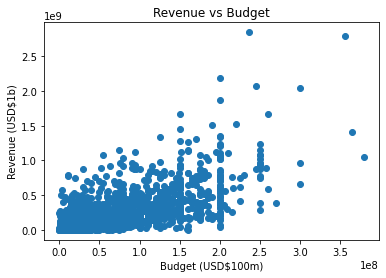

In [8]:
# visualise
fig = plt.figure(facecolor="white")
plt.scatter(films_with_budget_and_revenue["budget"], films_with_budget_and_revenue["revenue"])

plt.title("Revenue vs Budget")

plt.xlabel("Budget (USD$100m)")
plt.ylabel("Revenue (USD$1b)")

plt.draw()
plt.show()

In [9]:
raw_data[vote_cols].describe()

,vote_average,vote_count
count,5000.00,5000.00
mean,6.50,2195.85
std,1.24,3397.82
min,0.00,0.00
25%,6.00,186.00
50%,6.60,867.50
75%,7.20,2707.25
max,10.00,31119.00


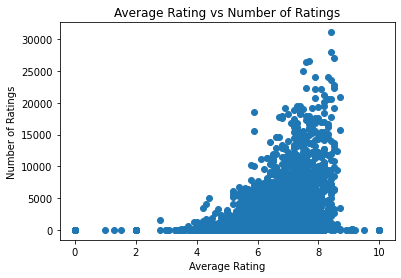

In [10]:
# visualise
fig = plt.figure(facecolor="white") # I am in dark mode
plt.scatter(raw_data["vote_average"], raw_data["vote_count"])

plt.title("Average Rating vs Number of Ratings")

plt.xlabel("Average Rating")
plt.ylabel("Number of Ratings")

plt.draw()
plt.show()

In [11]:
raw_data["runtime"].describe()

count   4999.00
mean     100.66
std       28.45
min        0.00
25%       90.00
50%      100.00
75%      115.00
max      248.00
Name: runtime, dtype: float64

It does not make sense for a film to have zero runtime, so let's check how many 
films have zero runtime.

In [12]:
len(raw_data[raw_data["runtime"] == 0])

90

We should remove these films and see the effect. 

In [13]:
raw_data[raw_data["runtime"] > 0]["runtime"].describe()

count   4909.00
mean     102.51
std       25.20
min        1.00
25%       90.00
50%      100.00
75%      115.00
max      248.00
Name: runtime, dtype: float64

It seems it had little to no effect on the distribution. Nonetheless, we plot 
the distribution of runtimes of films with non-zero runtimes. 

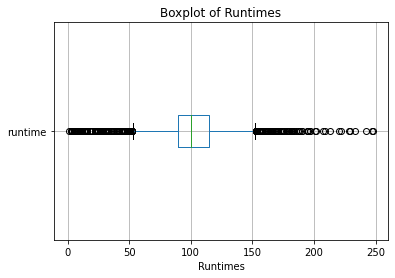

In [14]:
# visualise
fig = plt.figure(facecolor="white") # I am in dark mode
raw_data[raw_data["runtime"] > 0].boxplot("runtime", vert=False)

plt.title("Boxplot of Runtimes")

plt.xlabel("Runtimes")

plt.draw()
plt.show()

## Correlation Matrix
For reference, we also show the correlation matrix.

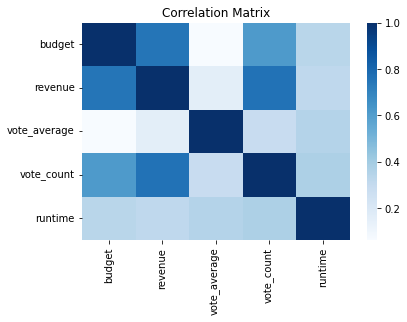

In [15]:
numerical_cols = (financial_cols + vote_cols)
numerical_cols.append("runtime")

# # visualise
fig = plt.figure(facecolor="white")
sb.heatmap(raw_data[numerical_cols].corr(), cmap="Blues")

plt.title("Correlation Matrix")

plt.show()


## Distribution of Genres
What is the most common genre of movie? What is the least common?

In [16]:
genres_flat = flatten(raw_data[["id", "title", "genres"]], ["genres"])

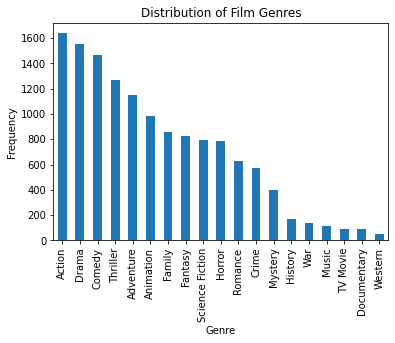

In [17]:
# visualise
fig = plt.figure(facecolor="white")
genres_flat["genres"].value_counts().plot.bar()
plt.title("Distribution of Film Genres")
plt.xlabel("Genre")
plt.ylabel("Frequency")
plt.show()

## Award for Most Hardworking
For some models, it may be preferable to recategorise cast and crew data into top 10 vs else. For example, it might make more sense to separate casts into top 10 most commonly occurring actors and an additional category for all others. 

Here we see who the most 'hardworking' cast and crew members by separating the 
top 10 members vs everyone else. 

In [18]:
# flatten cast data
cast_flatten = flatten_people(raw_data[["id", "title", "cast"]], "cast")
cast_flatten.sample(5)

,adult,gender,cast_tmdb_id,known_for_department,cast_name,original_name,popularity,profile_path,cast_id,character,credit_id,order,movie_id,movie_title
31,False,0.00,1114051.00,Acting,Reed Buck,Reed Buck,3.21,/lw3sqTcIRPqg8aPpzkXLVhxFNwP.jpg,59.00,Additional Voice (voice),55e41abb92514137dd00351f,31.00,177572,Big Hero 6
12,False,0.00,2928737.00,Acting,Leon Andrew Joseph,Leon Andrew Joseph,0.60,None,87.00,Jerome,5ff8fe32383df2003b3383ec,12.00,500916,Primal
26,False,2.00,34979.00,Acting,Loren Lester,Loren Lester,2.53,/AmdxCKx7ehFXtOglUH02iewTHqI.jpg,84.00,Mike's Lawyer,56c5a80ac3a3680d570025f1,26.00,16996,17 Again
7,False,2.00,1235542.00,Acting,John Sampson,John Sampson,2.36,/wSz5QgcgFTOyMSfDF62iiMRilfg.jpg,10.00,Police Officer,6184c5f0e7414600438c1b91,8.00,768449,American Badger
8,False,2.00,1554515.00,Acting,Benjamin Haigh,Benjamin Haigh,2.32,/9PKwxJfYOgxAkZurTTY17EdIPGY.jpg,80.00,Billy Hodgson,57ca7389c3a3686261000b3f,8.00,259693,The Conjuring 2


In [19]:
# get frequency count of every cast member
cast_dist = cast_flatten["cast_name"].value_counts()

# set top x number of cast members
top_x = 20
# index the top x cast members
top_x_cast = pd.Series(cast_dist[0:top_x])
# compute the number of films done by everyone else outside of the top x
# other_cast = pd.Series({"Others": sum(cast_dist[top_x + 1:])})

# rejoin the series as top x vs everyone else
# cast_dist = pd.concat([top_x_cast, other_cast])


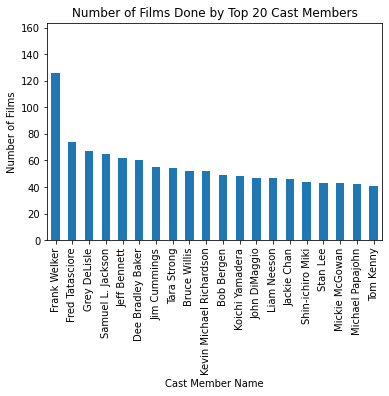

In [20]:
# visualise
fig = plt.figure(facecolor="white")
top_x_cast.plot.bar()

plt.title("Number of Films Done by Top {} Cast Members".format(top_x))

plt.xlabel("Cast Member Name")
plt.ylabel("Number of Films")

plt.ylim([0, max(top_x_cast) * 1.3])

plt.show()

## Unoriginality of Movies
People often complain that movies are becoming more and more similar and that studios are pushing out more and more remakes. Might movies be getting more similar? 

Let's look at the distribution and similarity of keywords and taglines in our dataset. Again we apply the principle of top `y` keywords vs the rest. 

In [21]:
# flatten according to keywords
keywords_flat = flatten(raw_data[["id", "title", "keywords"]], ["keywords"])

In [22]:
# get frequency distribution 
keywords_dist = keywords_flat["keywords"].value_counts()

# define top y keywords
top_y = 20
# get top y keywords
top_y_keywords = pd.Series(keywords_dist[0:top_y])
# get others
other_keywords = pd.Series({"Others": sum(keywords_dist[top_y+1:])})

# rejoin the series as top y vs everyone else
keywords_dist = pd.concat([top_y_keywords, other_keywords])
keywords_dist

based on novel or book         448
sequel                         290
anime                          285
duringcreditsstinger           252
murder                         227
based on comic                 202
revenge                        188
superhero                      186
woman director                 174
martial arts                   165
dystopia                       157
aftercreditsstinger            151
based on true story            149
friendship                     131
remake                         130
magic                          121
new york city                  118
super power                    115
alien                          113
parent child relationship      108
Others                       35523
dtype: int64

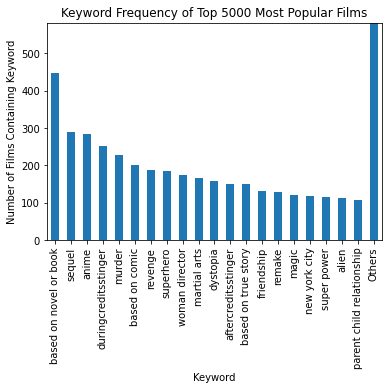

In [23]:
# visualisation
fig = plt.figure(facecolor="white")
keywords_dist.plot.bar()

plt.title("Keyword Frequency of Top 5000 Most Popular Films")

plt.xlabel("Keyword")
plt.ylabel("Number of Films Containing Keyword")

plt.ylim([0, max(top_y_keywords) * 1.3])

plt.show()

## The Good Old Days
Not only do people complain about movies feeling more and more unoriginal, they also complain that movies are getting worse over the years. Is this true? Are recent movies receiving worse ratings than old movies?

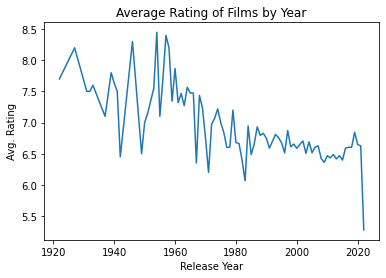

In [24]:
# compute average rating of films in each year
released_films = raw_data[raw_data["released"] == True]
avg_rating_by_year = released_films.groupby(released_films["release_date"].dt.year)["vote_average"].mean()

# visualisation
fig = plt.figure(facecolor="white")
ax = plt.axes()
plt.plot(avg_rating_by_year)

# ax.scatter(raw_data["release_date"], raw_data["vote_average"])
plt.draw()

plt.title("Average Rating of Films by Year")

plt.xlabel("Release Year")
plt.ylabel("Avg. Rating")

plt.show()

The above plot seems to suggest that newer films have dropped severely in quality. However, our dataset of the top 5000 most popular movies as of March 10th, 2022 is perhaps not the best for this - survivorship bias is very obvious here (only good old films would be popular now). We should examine the number of votes as well. 

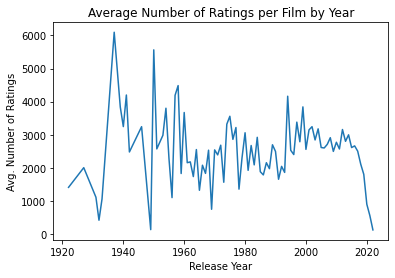

In [25]:
avg_vote_count_by_year = released_films.groupby(released_films["release_date"].dt.year)["vote_count"].mean()

# visualisation
fig = plt.figure(facecolor="white")
ax = plt.axes()
plt.plot(avg_vote_count_by_year)
plt.draw()

plt.title("Average Number of Ratings per Film by Year")

plt.xlabel("Release Year")
plt.ylabel("Avg. Number of Ratings")

plt.show()

Surprisingly, there are fewer votes for in recent years! This could be attributed to factors such as good older movies being more popular and thus more likely to be rated, fewer users using the platform after the 2010’s, or even the slowdown in movie production in the past 2.5 years (due to COVID-19). Whatever the reason, it seems that most of the top 5000 most popular movies are older, more likely to be rated, and more likely to be rated higher! 

## Inflation-Adjusted Budgets and Revenues Over Time
Let's have a look at the finances of films over time. Using the datasets cleaned
of zero values, first we simply plot average budgets and revenues of films by 
release year. 

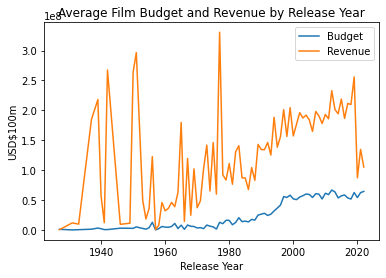

In [26]:
avg_budget_by_year = films_with_budget_and_revenue.groupby(films_with_budget_and_revenue["release_date"].dt.year)["budget"].mean() 

avg_revenue_by_year = films_with_budget_and_revenue.groupby(films_with_budget_and_revenue["release_date"].dt.year)["revenue"].mean()

# visualisation
fig = plt.figure(facecolor="white")
ax = plt.axes()
plt.plot(avg_budget_by_year, label="Budget")
plt.plot(avg_revenue_by_year, label="Revenue")
plt.legend()
plt.draw()

plt.title("Average Film Budget and Revenue by Release Year")

plt.xlabel("Release Year")
plt.ylabel("USD$100m")

plt.show()

There is some very wild variance in the revenues over the years, while budgets 
follow a more reasonable trend. The most likely reason is that some revenue data 
points in the dataset are inflation-adjusted, while others are not, leading to 
skewed averages per year. 

This will prove to be a very difficult data cleaning job. For the purposes of 
this report, we keep the numbers as is for the following reasons:
- the main focus of this report is a demonstration of classification, regression,
and clustering algorithms
- the interests of time (I should probably return to my honours thesis)
- we have a reasonably large dataset
- this is just for fun, and when I am more free I will attempt to make the data 
more consistent. 

This concludes the exploratory data analysis. 

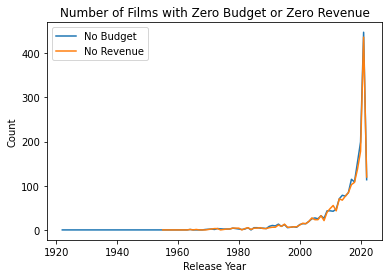

In [27]:
zero_budget_films = released_films[released_films["budget"] == 0]
zero_budget_films_by_year = zero_budget_films.groupby(zero_budget_films["release_date"].dt.year)["budget"].value_counts()
zero_budget_years = []
for i in range(len(zero_budget_films_by_year.index)):
    zero_budget_years.append(zero_budget_films_by_year.index[i][0])

zero_revenue_films = released_films[released_films["revenue"] == 0]
zero_revenue_films_by_year = zero_revenue_films.groupby(zero_revenue_films["release_date"].dt.year)["revenue"].value_counts()
zero_revenue_years = []
for i in range(len(zero_revenue_films_by_year.index)):
    zero_revenue_years.append(zero_revenue_films_by_year.index[i][0])

# visualisation
fig = plt.figure(facecolor="white")
ax = plt.axes()
plt.plot(zero_budget_years, zero_budget_films_by_year.values, label="No Budget")
plt.plot(zero_revenue_years, zero_revenue_films_by_year.values, label="No Revenue")
plt.legend()
plt.draw()

plt.title("Number of Films with Zero Budget or Zero Revenue")

plt.xlabel("Release Year")
plt.ylabel("Count")

plt.show()